In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
cities = ['ABZ', 'ALE', 'AMA', 'AMM', 'ASP', 'BEI', 'BOT', 'BSL', 'DEL', 'EGB',
          'HAD', 'HEL', 'HPB', 'HYY', 'KCE', 'KPZ', 'MAR', 'MHD', 'MLP', 'MUK', 
          'NAN', 'NEU', 'POV', 'SAO', 'SCH', 'SGP', 'UAE', 'VAR', 'VIE', 'WAL', 
          'ZOT']

In [53]:
data = pd.read_csv('data/full_data.csv', parse_dates=['date'])
data.head()

,id,station,date,n100,latitude,longitude,aermr01,aermr02,aermr03,aermr04,...,t2m,blh,co,c5h8,no2,no,so2,nh3,crwc,c10h16
0,ABZ-2012-01-26,ABZ,2012-01-26,2708.085714,50.57,12.99,6.752697e-12,5.765684e-10,3.351248e-11,2.513737e-15,...,268.37625,306.51462,3.418626e-07,1.845452e-11,2.060121e-08,1.302913e-08,6.464830e-09,8.448101e-10,0.0,2.113917e-10
1,ABZ-2012-01-27,ABZ,2012-01-27,2489.175000,50.57,12.99,4.223335e-12,3.600730e-10,1.855095e-11,2.457708e-12,...,267.83536,142.03300,3.787211e-07,2.230681e-11,2.199851e-08,1.489063e-08,7.113044e-09,1.008734e-09,0.0,2.499145e-10
2,ABZ-2012-01-28,ABZ,2012-01-28,3484.229167,50.57,12.99,3.553853e-12,3.007895e-10,2.072250e-10,2.348849e-11,...,269.69257,152.80160,5.185500e-07,3.481757e-11,1.887175e-08,3.310498e-08,7.495814e-09,1.407371e-09,0.0,4.513248e-10
3,ABZ-2012-01-29,ABZ,2012-01-29,2977.512500,50.57,12.99,8.665312e-12,7.307493e-10,5.219741e-11,1.661040e-10,...,269.08804,461.47455,3.129840e-07,1.296726e-11,1.569601e-08,4.424891e-09,4.929475e-09,1.466395e-09,0.0,1.150862e-10
4,ABZ-2012-01-30,ABZ,2012-01-30,2702.463636,50.57,12.99,1.436837e-11,1.208825e-09,5.724685e-11,1.925855e-10,...,267.95770,610.29910,2.414889e-07,8.755192e-12,1.345031e-08,1.021235e-09,5.219232e-09,1.477080e-09,0.0,4.446712e-11


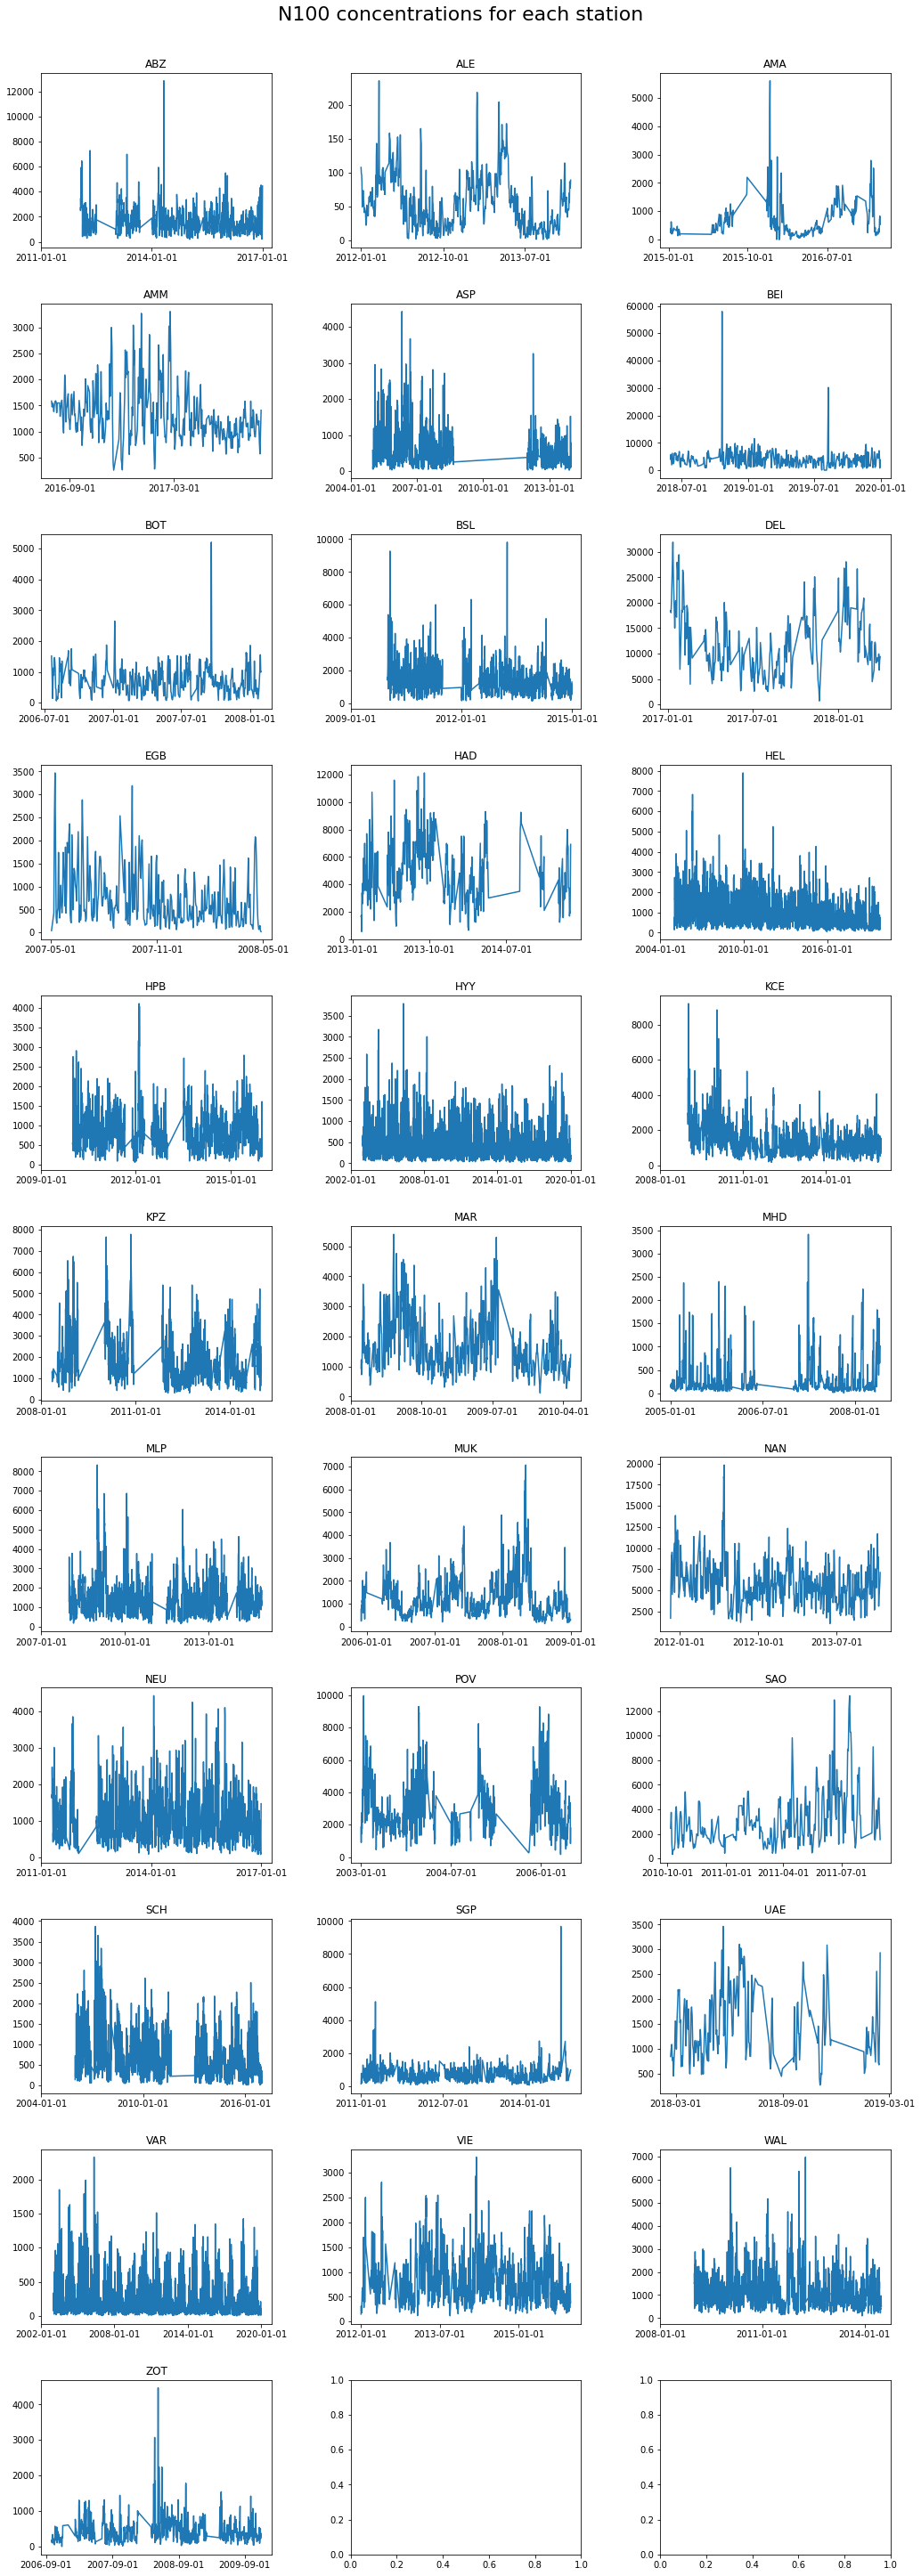

In [54]:
fig, axes = plt.subplots(11,3, figsize=(15,40))
axes = iter(axes)
i = 0

for c in cities:
    if i%3 == 0:
        axis = next(axes)
    ax = axis[i%3]
    
    ax.plot(data.date.loc[data.station == c], data.n100.loc[data.station == c])
    ax.set_title(c)
    ax.set_xticks(ax.get_xticks()[::3])
    
    i += 1
    
fig.tight_layout(pad=3)
fig.suptitle('N100 concentrations for each station', y=1.01, fontsize=22);